In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.patches as mpatches

In [2]:
# Load the dataset from CSV
time_series_dataset = pd.read_csv('../outputs/mutation_timeseries3.csv', skiprows=1)

# Convert the dataset to float32
time_series_dataset = time_series_dataset.astype('float32')
print('Dataset Shape: ', time_series_dataset.shape)

# Apply Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(time_series_dataset)

# Split dataset into train and test sets
train_size = int(len(dataset_scaled) * 0.90)
train, test = dataset_scaled[:train_size], dataset_scaled[train_size:]
print(len(train), len(test))


Dataset Shape:  (806, 12)
725 81


In [3]:
def create_dataset(time_series_dataset, look_back, batch_size):
    dataX, dataY = [], []
    for i in range(0, len(time_series_dataset) - look_back - 1, batch_size):
        a = time_series_dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(time_series_dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

batch_size = 1
look_back = 12
trainX, trainY = create_dataset(train, look_back, batch_size)
testX, testY = create_dataset(test, look_back, batch_size)
print(len(trainX), len(testX))


712 68


In [4]:
# Build and Train Bidirectional LSTM Network
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, len(time_series_dataset.columns))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(len(time_series_dataset.columns)))
model.compile(loss='mean_squared_error', optimizer='adam')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

history = model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=2, validation_data=(testX, testY), callbacks=[early_stop, reduce_lr])




Epoch 1/100

45/45 - 10s - loss: 0.0219 - val_loss: 3.9338e-04 - lr: 0.0010 - 10s/epoch - 214ms/step
Epoch 2/100
45/45 - 0s - loss: 0.0081 - val_loss: 7.3336e-04 - lr: 0.0010 - 482ms/epoch - 11ms/step
Epoch 3/100
45/45 - 0s - loss: 0.0059 - val_loss: 6.0404e-04 - lr: 0.0010 - 476ms/epoch - 11ms/step
Epoch 4/100
45/45 - 0s - loss: 0.0059 - val_loss: 4.2890e-04 - lr: 0.0010 - 489ms/epoch - 11ms/step
Epoch 5/100
45/45 - 0s - loss: 0.0060 - val_loss: 5.1872e-04 - lr: 0.0010 - 487ms/epoch - 11ms/step
Epoch 6/100
45/45 - 1s - loss: 0.0052 - val_loss: 1.8528e-04 - lr: 0.0010 - 641ms/epoch - 14ms/step
Epoch 7/100
45/45 - 1s - loss: 0.0049 - val_loss: 1.9413e-04 - lr: 0.0010 - 525ms/epoch - 12ms/step
Epoch 8/100
45/45 - 1s - loss: 0.0041 - val_loss: 1.7314e-04 - lr: 0.0010 - 601ms/epoch - 13ms/step
Epoch 9/100
45/45 - 1s - loss: 0.0035 - val_loss: 2.7173e-04 - lr: 0.0010 - 522ms/epoch - 12ms/step
Epoch 10/100
45/45 - 1s - loss: 0.0040 - val_loss: 9.2987e-04 - lr: 0.0010 - 518ms/epoch - 12ms/s

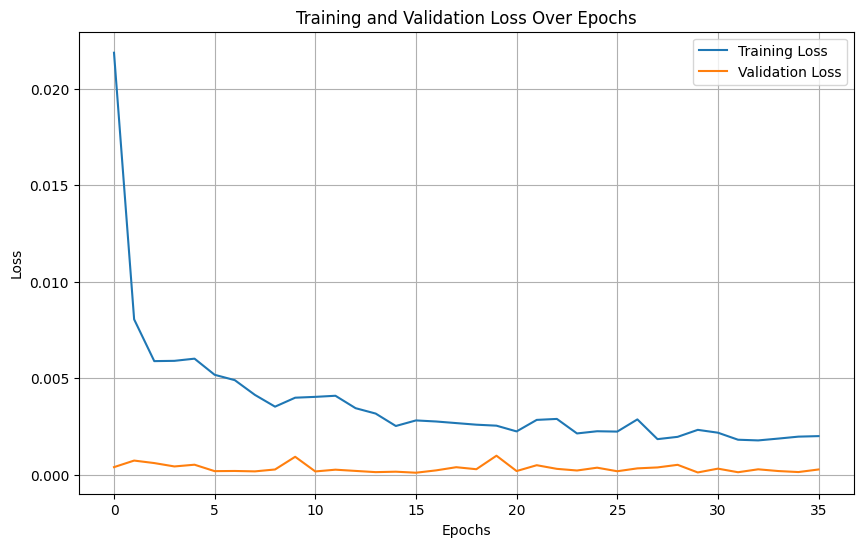

In [5]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


3/3 [==============================] - 0s 4ms/step
Train Score: 0.01 RMSE
Test Score: 0.00 RMSE
Train Score: 0.00 MAE
Test Score: 0.00 MAE


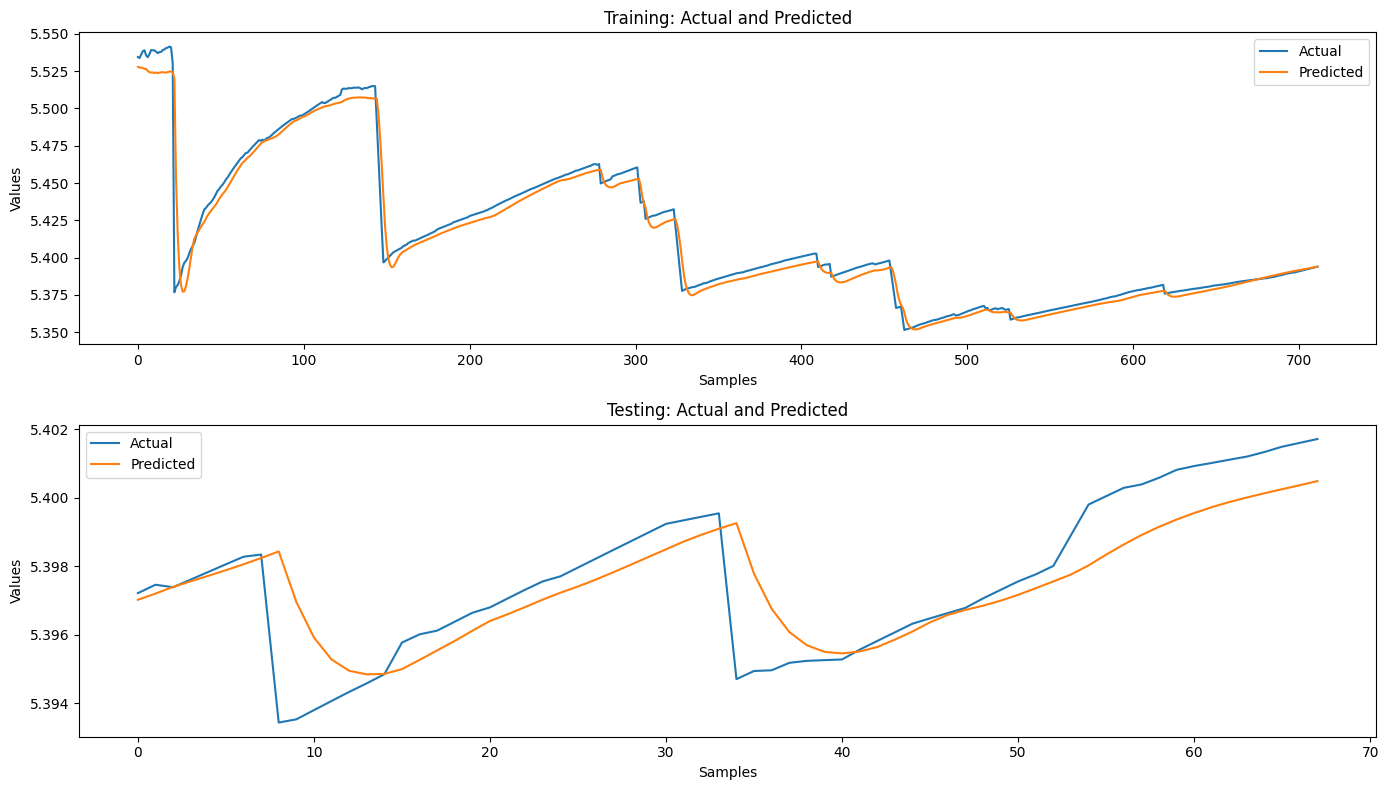

In [6]:
# Predicting
trainPredict = model.predict(trainX, verbose=1)
testPredict = model.predict(testX, verbose=1)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# Calculating error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print(f'Test Score: {testScore:.2f} RMSE')

trainMAE = mean_absolute_error(trainY, trainPredict)
testMAE = mean_absolute_error(testY, testPredict)
print(f'Train Score: {trainMAE:.2f} MAE')
print(f'Test Score: {testMAE:.2f} MAE')

# Plotting the predictions
plt.figure(figsize=(14, 8))

# Plotting train predictions
plt.subplot(2, 1, 1)
plt.plot(trainY[:, 0], label='Actual')
plt.plot(trainPredict[:, 0], label='Predicted')
plt.title('Training: Actual and Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

# Plotting test predictions
plt.subplot(2, 1, 2)
plt.plot(testY[:, 0], label='Actual')
plt.plot(testPredict[:, 0], label='Predicted')
plt.title('Testing: Actual and Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

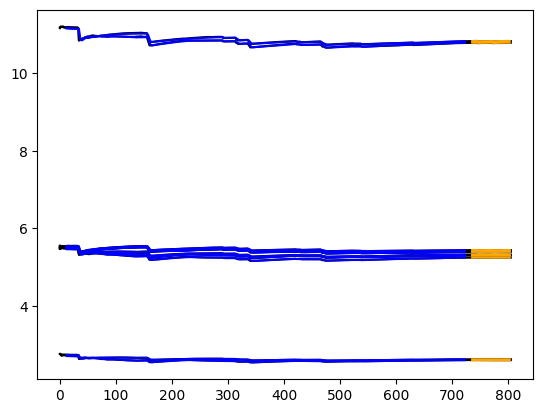

In [7]:
# Shift train predictions for plotting
trainPredictPlot = np.empty((len(trainX) + look_back, len(time_series_dataset.columns)))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainX) + look_back] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty((len(dataset_scaled), len(time_series_dataset.columns)))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainX) + (look_back*2):len(trainX) + len(testY) + (look_back*2)] = testPredict

# Plot baseline and predictions
dset = scaler.inverse_transform(dataset_scaled)
plt.plot(dset, color="black", label='Original Data')
plt.plot(trainPredictPlot, color="blue", label='Training Result')
plt.plot(testPredictPlot, color="orange", label='Testing Result')


1/1 [==============================] - 0s 26ms/step


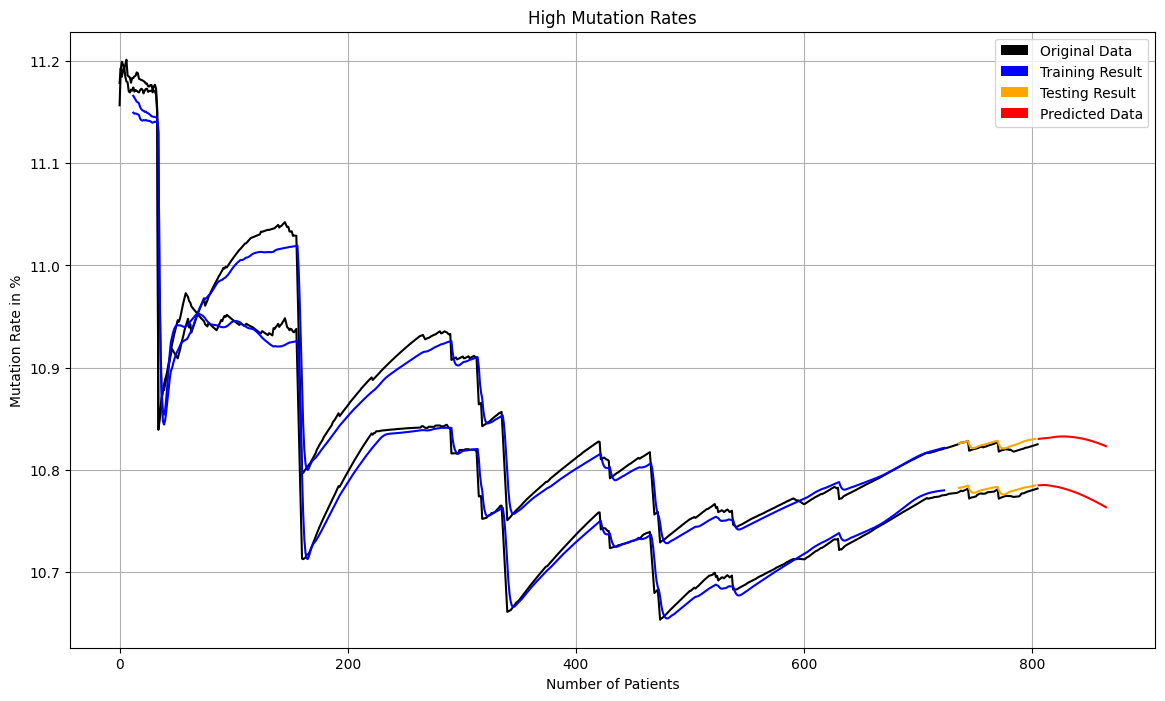

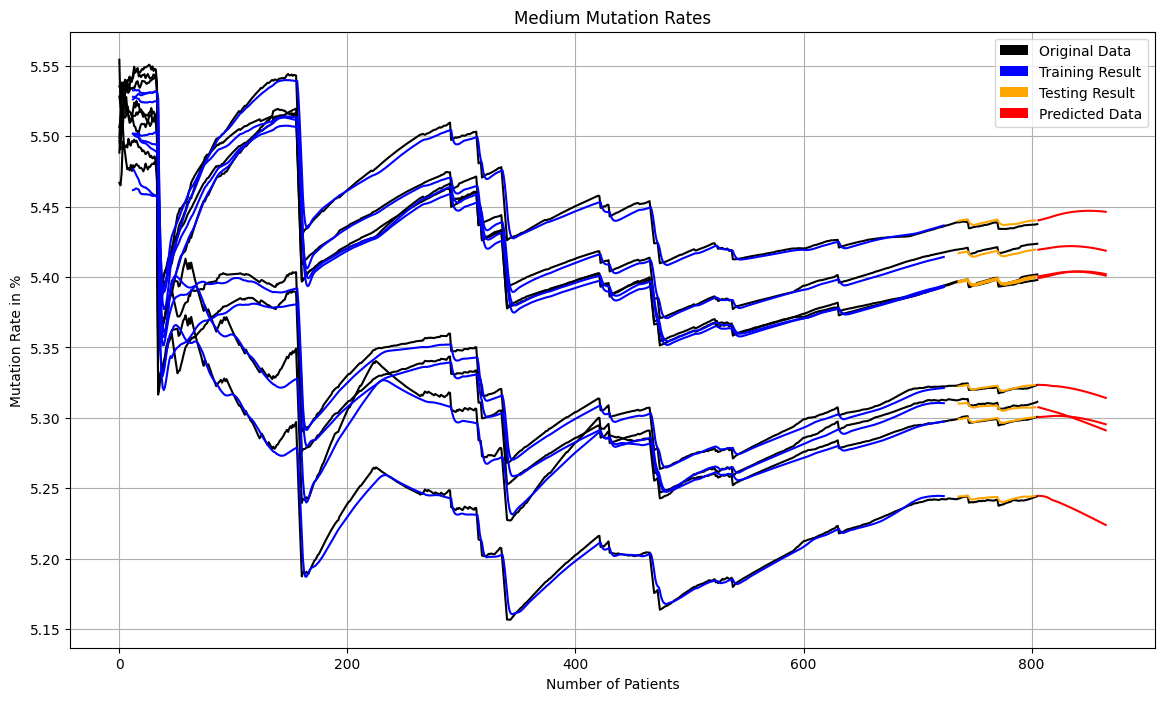

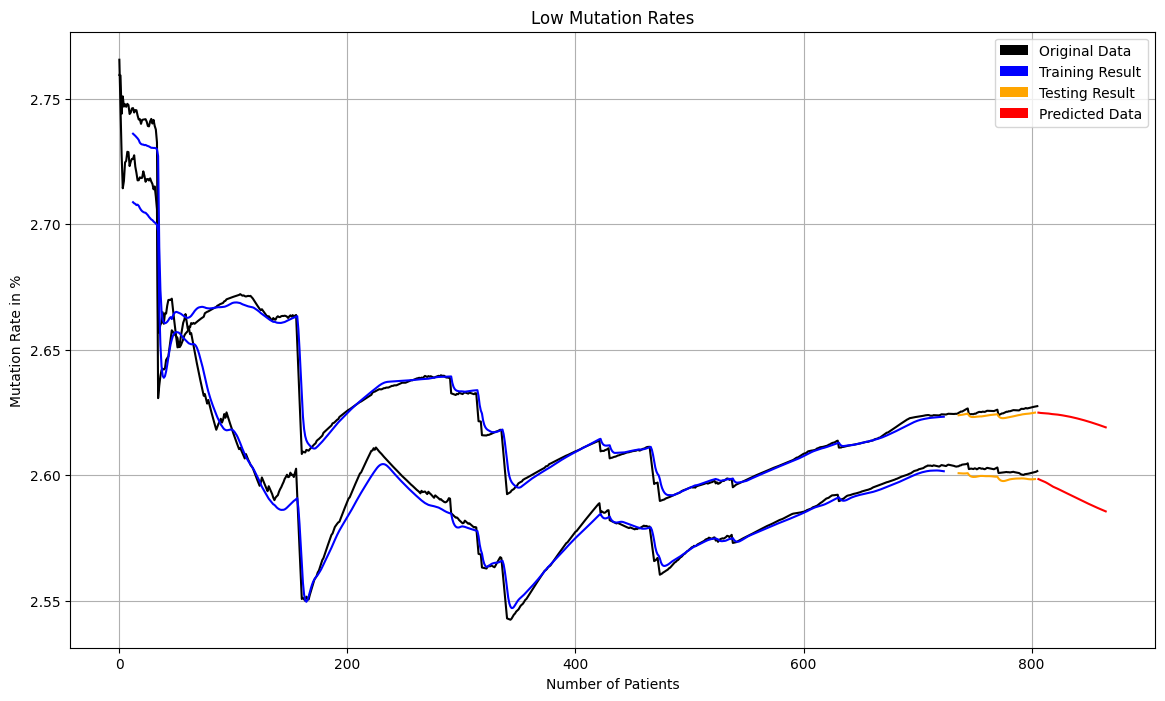

In [8]:
# Split the data based on mutation rate categories
high_mutation_rates = ['T->A', 'A->T']
medium_mutation_rates = ['T->C', 'C->T', 'A->C', 'C->A', 'A->G', 'G->A', 'G->T', 'T->G']
low_mutation_rates = ['G->C', 'C->G']

# Columns in the dataset
columns = ['T->C', 'T->A', 'T->G', 'C->A', 'C->G', 'A->G', 'C->T', 'A->T', 'G->T', 'A->C', 'G->C', 'G->A']

# Indices for each category
high_indices = [columns.index(col) for col in high_mutation_rates]
medium_indices = [columns.index(col) for col in medium_mutation_rates]
low_indices = [columns.index(col) for col in low_mutation_rates]

# Function to get category data
def get_category_data(data, indices):
    return data[:, indices]

# Plotting function
def plot_data(title, original_data, trainPredict, testPredict, futurePredictions, indices):
    dset = original_data[:, indices]
    trainPredictPlot = np.empty((len(trainX) + look_back, len(indices)))
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainX) + look_back] = trainPredict[:, indices]

    testPredictPlot = np.empty((len(dataset_scaled), len(indices)))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainX) + (look_back * 2):len(trainX) + len(testY) + (look_back * 2)] = testPredict[:, indices]

    futurePredictPlot = np.empty((len(dset) + len(futurePredictions), len(indices)))
    futurePredictPlot[:, :] = np.nan
    futurePredictPlot[len(dset):len(dset) + len(futurePredictions)] = futurePredictions[:, indices]

    plt.figure(figsize=(14, 8))
    plt.plot(dset, color="black", label='Original Data')
    plt.plot(trainPredictPlot, color="blue", label='Training Result')
    plt.plot(testPredictPlot, color="orange", label='Testing Result')
    plt.plot(futurePredictPlot, color="red", label='Predicted Data')

    black_patch = mpatches.Patch(color='black', label='Original Data', linewidth=0)
    blue_patch = mpatches.Patch(color='blue', label='Training Result', linewidth=0)
    orange_patch = mpatches.Patch(color='orange', label='Testing Result', linewidth=0)
    red_patch = mpatches.Patch(color='red', label='Predicted Data', linewidth=0)
    plt.legend(handles=[black_patch, blue_patch, orange_patch, red_patch])

    plt.xlabel('Number of Patients')
    plt.ylabel('Mutation Rate in %')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Inverse transform the entire dataset
original_data = scaler.inverse_transform(dataset_scaled)

# Generate future predictions
futureData = [testX[-1]]
futurePredictions = []

for i in range(60):  # Predict next 60 steps
    futurePredict = model.predict(np.array(futureData[-1]).reshape(1, look_back, len(time_series_dataset.columns)))
    futurePredictions.append(futurePredict)
    futureData.append(np.roll(futureData[-1], -1, axis=0))
    futureData[-1][-1] = futurePredict

futurePredictions = np.array(futurePredictions).reshape(-1, len(time_series_dataset.columns))
futurePredictions = scaler.inverse_transform(futurePredictions)

# Plotting for each category
for title, indices in zip(
    ["High Mutation Rates", "Medium Mutation Rates", "Low Mutation Rates"],
    [high_indices, medium_indices, low_indices]
):
    plot_data(title, original_data, trainPredict, testPredict, futurePredictions, indices)